In [ ]:
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tensorflow as tf
import time

In [ ]:
class Image:
    # Loads an image from path, returns a tensor with values in [0, 1]

    def load_img(img_path, max_dim=512):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)

        shape = tf.cast(tf.shape(img)[:-1], tf.float32)
        long_dim = max(shape)
        scale = max_dim / long_dim

        new_shape = tf.cast(scale * shape, tf.int32)

        img = tf.image.resize(img, new_shape)
        img = img[tf.newaxis, :]
        return img

    def tensor_to_image(tensor):
        # Convert value range from [0, 1] to [0, 255]
        tensor = tensor * 255
        tensor = np.array(tensor, dtype=np.uint8)

        # Reduce tensor dimension if appropriate
        if np.ndim(tensor) > 3:
            assert tensor.shape[0] == 1
            tensor = tensor[0]

        return PIL.Image.fromarray(tensor)

    def clip_0_1(img):
        return tf.clip_by_value(img, clip_value_min=0.0, clip_value_max=1.0)

    def display_image(img, title=None):
        if len(img.shape) > 3:
            img = tf.squeeze(img, axis=0)

        plt.imshow(img)
        if title:
            plt.title(title)

In [ ]:
content_path = "/content/stanly__.jpg"
style_path = "/content/lisa__.jpg"

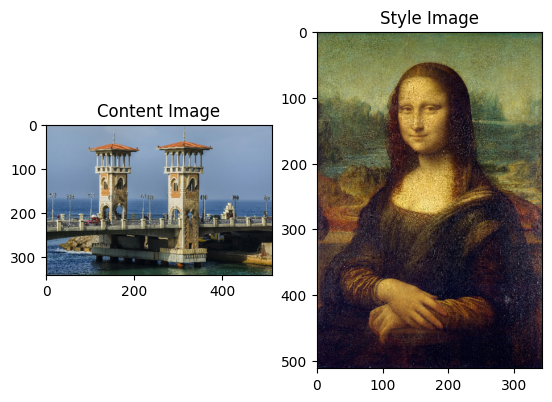

In [ ]:
plt.subplot(1, 2, 1)
Image.display_image(Image.load_img(content_path), 'Content Image')

plt.subplot(1, 2, 2)
Image.display_image(Image.load_img(style_path), 'Style Image')

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.model = StyleContentModel.vgg_layers(style_layers + content_layers)
        self.model.trainable = False

        self.style_layers = style_layers
        self.content_layers = content_layers

        self.num_content_layers = len(content_layers)
        self.num_style_layers = len(style_layers)

    def call(self, inputs):
        # Expects tensor with values ranged [0,1]
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.model(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [StyleContentModel.gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

    # Compute Gram Matrix, specified from the paper

    def gram_matrix(input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
        return result / num_locations

    # Extract selected VGG19 layers and return a new model

    def vgg_layers(layer_names):
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False

        outputs = [vgg.get_layer(name).output for name in layer_names]

        model = tf.keras.Model([vgg.input], outputs)
        return model

In [ ]:
class NeuralStyleTransfer:
    def __init__(self, model, content_img_path, style_img_path, max_dim=512,
                 content_weight=1e4, style_weight=1e-2, total_variation_weight=30,
                 optimizer=tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)):
        self.max_dim = max_dim
        self.model = model

        self.content_img = Image.load_img(content_img_path)
        self.style_img = Image.load_img(style_img_path)
        self.result_img = tf.Variable(self.content_img)

        self.content_targets = self.model(self.content_img)['content']
        self.style_targets = self.model(self.style_img)['style']

        self.content_weight = content_weight
        self.style_weight = style_weight

        self.optimizer = optimizer
        self.total_variation_weight = total_variation_weight

    # Compute loss
    def style_content_loss(self, outputs):
        style_outputs = outputs['style']
        content_outputs = outputs['content']

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - self.content_targets[name]) ** 2) for name in content_outputs.keys()])
        content_loss *= self.content_weight / self.model.num_content_layers

        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - self.style_targets[name]) ** 2) for name in style_outputs.keys()])
        style_loss *= self.style_weight / self.model.num_style_layers

        loss = style_loss + content_loss
        return loss

    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            outputs = self.model(self.result_img)
            loss = self.style_content_loss(outputs)

            # Regularization term on the high frequency components of the image
            loss += self.total_variation_weight * tf.image.total_variation(self.result_img)

        grad = tape.gradient(loss, self.result_img)
        self.optimizer.apply_gradients([(grad, self.result_img)])
        self.result_img.assign(Image.clip_0_1(self.result_img))

    # Transfer style to the resulting image
    def train(self, epochs, steps_per_epoch=50):
        start = time.time()
        step = 0
        for n in range(epochs):
            for m in range(steps_per_epoch):
                step += 1
                self.train_step()
                print(".", end='', flush=True)
            display.clear_output(wait=True)
            display.display(Image.tensor_to_image(self.result_img))
            print("Train step: {}".format(step))

        end = time.time()
        print("Total time: {:.1f}".format(end - start))

    # Save results in the working directory
    def export_results(self, file_name):
        img = Image.tensor_to_image(self.result_img)
        img.save(file_name)

In [ ]:
model = StyleContentModel(style_layers, content_layers)
nst = NeuralStyleTransfer(model, content_path, style_path, max_dim=1024)

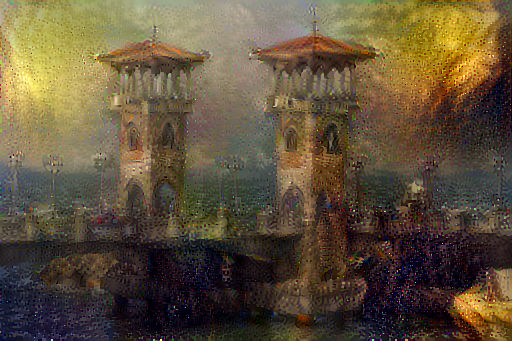

Train step: 5000
Total time: 321.8


In [ ]:
nst.train(100)
